# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [19]:
import pandas as pd
import numpy as np
import os

# Suppress TensorFlow logging warnings to reduce console output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    df = pd.read_csv(path, encoding="ISO-8859-2")
    
    if train:
        data = df.sample(frac=1, random_state=42).values
        # Restituisci le feature (colonne da 1 a -1) e i label (ultima colonna)
        return data[:, :-1].astype(np.float32), data[:, -1]
    
    # Nel caso del test, restituisci tutto tranne la prima colonna come feature
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Carica i dati di training e test
X_train, labels = load_data('./train.csv')
X_test, ids = load_data('./test.csv', train=False)

print(f"Training set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())
print("\nLabels distribution:\n", pd.Series(labels).value_counts())
print("\nMissing values:\n", pd.read_csv('./train.csv').isnull().sum())
print("\nSummary statistics:\n", pd.read_csv('./train.csv').describe())
print("\nTest set dimensions:", X_test.shape)


Training set dimensions: (25500, 24)
Features count: 24

First 5 training samples:
         0         1    2    3    4     5    6    7    8    9   ...       14  \
0  21870.0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  15211.0  320000.0  2.0  2.0  2.0  28.0  0.0  0.0  0.0  0.0  ...    944.0   
2  20041.0   30000.0  2.0  2.0  2.0  36.0  0.0  0.0  0.0  0.0  ...  30452.0   
3   9190.0   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  ...  18621.0   
4   6260.0   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  ...  28242.0   

        15       16       17      18       19      20      21      22      23  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0      0.0      0.0     7.0   12

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

Missing values:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


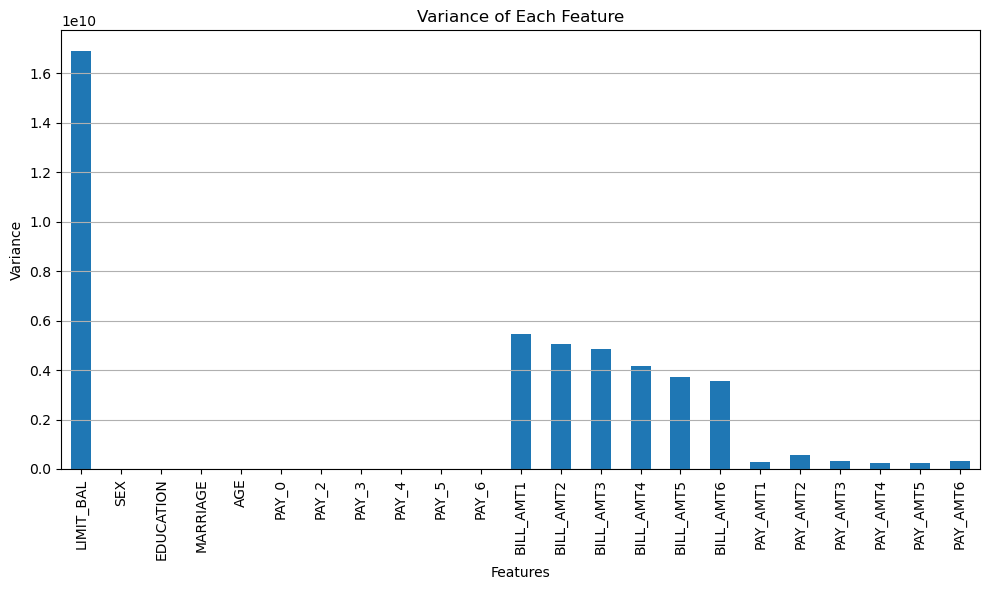

Shapes -> Train: (17850, 23), Val: (7650, 23), Encoded Train: (17850,), Encoded Val: (7650,)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def preprocess_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(X)
    return scaler.transform(X), scaler

# Carica i dati di training e test
df_train = pd.read_csv('./train.csv')

# Separare le etichette
labels_raw = df_train['default payment next month']

# Colonne da eliminare (inclusa la colonna ID)
columns_to_drop = ["ID"]

# Creare il DataFrame delle features
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])

# Controlla valori mancanti
print("Missing values:\n", df_train.isnull().sum())

# Visualizza la varianza delle feature
plt.figure(figsize=(10, 6))
X_train_raw.var().plot(kind='bar')
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Divisione in set di training e validazione
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.3, random_state=42, stratify=labels_raw)

# Ridimensionamento delle feature
X_train_scaled, scaler = preprocess_data(X_train)
X_val_scaled, _ = preprocess_data(X_val, scaler)

# Mostra la dimensione dei set
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, "
      f"Encoded Train: {y_train.shape}, Encoded Val: {y_val.shape}")


## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [21]:
from keras.src.utils import plot_model
from keras.src.optimizers import Adam
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras import Sequential, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score

# Definizione del modello
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))  # Uscita per classificazione binaria
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)

batch_size = 128
epochs = 150

model.summary()

# Definizione delle callback per l'early stopping e la riduzione del learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Callback personalizzata per visualizzare i progressi durante l'addestramento
class ProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
    
    def on_epoch_end(self, epoch, logs=None):
        metrics = (f"Epoch {self.epoch + 1}/{self.params['epochs']} - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Accuracy: {logs['accuracy']:.4f} - "
                   f"Val Accuracy: {logs['val_accuracy']:.4f}")
        print("\r" + metrics, end='')

# Addestramento del modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],
                    verbose=1)

# Valutazione del modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

print()
print("\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Previsione e calcolo dell'F1 Score
y_pred_prob = model.predict(X_val_scaled, verbose=0) 
y_pred = (y_pred_prob > 0.5).astype(int)

f1 = f1_score(y_val, y_pred)
print(f"{'F1 Score:':<20} {f1:.4f}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 50,369 (196.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5420 - loss: 4.1530 - val_accuracy: 0.7817 - val_loss: 3.7830 - learning_rate: 1.0000e-04
Epoch 2/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6276 - loss: 3.8259 - val_accuracy: 0.8047 - val_loss: 3.5196 - learning_rate: 1.0000e-04
Epoch 3/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6771 - loss: 3.5654 - val_accuracy: 0.8075 - val_loss: 3.2989 - learning_rate: 1.0000e-04
Epoch 4/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7159 - loss: 3.3230 - val_accuracy: 0.8105 - val_loss: 3.0897 - learning_rate: 1.0000e-04
Epoch 5/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7400 - loss: 3.1107 - val_accuracy: 0.8144 - val_loss: 2.8870 - learning_rate: 1.0000e-04
Epoch 6/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7545 - loss: 2.9056 - val_accuracy: 0.8149 - val_loss: 2.6960 - learning_rate: 1.0000e-04
Epoch 7/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc

In [7]:

from keras.src.utils import plot_model
from keras.src.optimizers import Adam
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras import Sequential, Input
# Importing necessary libraries and modules from Keras and Scikit-learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Initialize a StandardScaler object for feature scaling
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)  

# Transform the validation data using the same scaler (to avoid data leakage)
X_val_scaled = scaler.transform(X_val) 

def build_model(input_shape):
    """
    Builds a sequential neural network model.

    Parameters:
    input_shape (int): The number of input features.

    Returns:
    model (Sequential): A compiled Keras Sequential model.
    """
    model = Sequential()  # Initialize a Sequential model
    model.add(Input(shape=(input_shape,)))  # Input layer with the specified shape

    # First hidden layer with 256 units, ReLU activation, and L2 regularization
    model.add(Dense(256, activation='relu', kernel_regularizer='l2')) 

    # Second hidden layer with 128 units, ReLU activation, and L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))


    # Third hidden layer with 64 units, ReLU activation, and L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))

    # Fourth hidden layer with 32 units, Leaky ReLU activation, and L2 regularization
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))

    # Output layer with a single unit and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))  

    # Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model  # Return the compiled model

# Determine the input shape based on the scaled training data
input_shape = X_train_scaled.shape[1]  
# Build the model with the defined input shape
model = build_model(input_shape)

# Set batch size and number of epochs for training
batch_size = 64
epochs = 200

# Outputs a model summary table
model.summary()

# Define an EarlyStopping callback to halt training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define a ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

class ProgressBar(Callback):
    """
    Custom callback to display training progress.

    Inherits from Keras Callback to provide additional functionality during training.
    """
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch  # Store the current epoch number
    
    def on_epoch_end(self, epoch, logs=None):
        # Format and print training metrics at the end of each epoch
        metrics = (f"Epoch {self.epoch + 1}/{self.params['epochs']} - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Accuracy: {logs['accuracy']:.4f} - "
                   f"Val Accuracy: {logs['val_accuracy']:.4f}")
        print("\r" + metrics, end='')  # Print metrics on the same line

# Train the model using the fit method with training and validation data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],
                    verbose=1)  # Set verbose to 0 to suppress output

# Evaluate the model's performance on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

# Print results for validation loss and accuracy
print()
print("\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Generate predictions on the validation set and convert probabilities to binary labels
y_pred_prob = model.predict(X_val_scaled, verbose=0) 
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score to evaluate the model's performance
f1 = f1_score(y_val, y_pred)  
print(f"{'F1 Score:':<20} {f1:.4f}")  # Print the F1 score

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6989 - loss: 3.6457 - val_accuracy: 0.7993 - val_loss: 2.6429 - learning_rate: 1.0000e-04
Epoch 2/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8009 - loss: 2.4062 - val_accuracy: 0.8075 - val_loss: 1.8136 - learning_rate: 1.0000e-04
Epoch 3/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8072 - loss: 1.6690 - val_accuracy: 0.8094 - val_loss: 1.3022 - learning_rate: 1.0000e-04
Epoch 4/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8132 - loss: 1.2075 - val_accuracy: 0.8110 - val_loss: 0.9891 - learning_rate: 1.0000e-04
Epoch 5/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8103 - loss: 0.9340 - val_accuracy: 0.8119 - val_loss: 0.7980 - learning_rate: 1.0000e-04
Epoch 6/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8137 - loss: 0.7627 - val_accuracy: 0.8093 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 7/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Generate predictions on the validation set
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Step 3: Classification Report
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Step 4: Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
Confusion Matrix:
[[5530  415]
 [1040  665]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.93      0.88      5945
     Default       0.62      0.39      0.48      1705

    accuracy                           0.81      7650
   macro avg       0.73      0.66      0.68      7650
weighted avg       0.79      0.81      0.79      7650

ROC AUC Score: 0.7469


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [58]:
# Load the test data
X_test, test_ids = load_data(url_test, train=False)

# Preprocess the test data
X_test_scaled, _ = preprocess_data(X_test)

# Step 1: Make predictions on the test set
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Create a DataFrame for submission or further analysis
results = pd.DataFrame({
    'Default_Prediction': y_test_pred.flatten()
})

# Step 3: Save predictions to a CSV file (optional)
results.to_csv('test_predictions.csv', index=False, header=False)

# Display predictions
print("Predictions on Test Set:")
print(results.head())


NameError: name 'url_test' is not defined

# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).